In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import precision_recall_curve, f1_score, recall_score, precision_score
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#CSV file read
df = pd.read_csv("/content/dibetics.csv")

In [ ]:
#set the graph style
plt.style.use('ggplot')
sns.set(style="whitegrid")

In [ ]:
# Display basic information about the dataset
print("\nDataset Overview:")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

print("\nDataset Information:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())

print("\nTarget Variable Distribution:")
print(df['Outcome'].value_counts())
print(f"Percentage of Diabetic Patients: {df['Outcome'].mean() * 100:.2f}%")

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check for zero values in columns where zeros are not physiologically possible
print("\nZero Values in Important Features:")
for column in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    zero_count = len(df[df[column] == 0])
    print(f"{column}: {zero_count} zeros ({zero_count/len(df)*100:.2f}%)")


Dataset Overview:
Shape: (768, 9)

First few rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancie

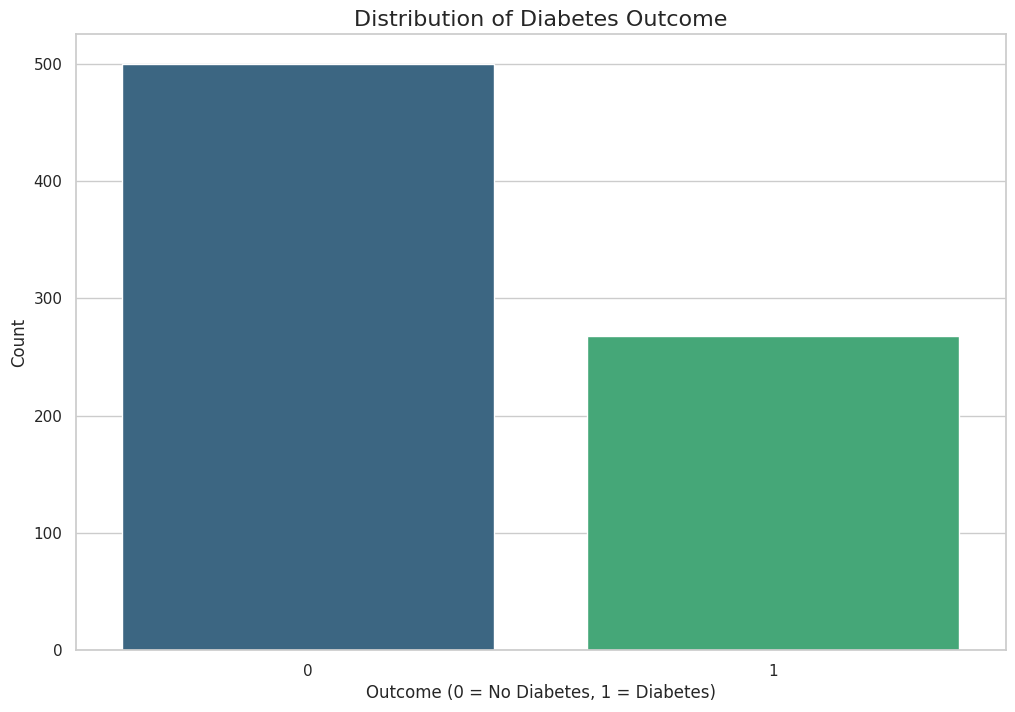

In [ ]:
#Data Visualization
plt.figure(figsize=(12, 8))
sns.countplot(x='Outcome', data=df, palette='viridis')
plt.title('Distribution of Diabetes Outcome', fontsize=16)
plt.xlabel('Outcome (0 = No Diabetes, 1 = Diabetes)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()
plt.close()

<Figure size 1200x1000 with 0 Axes>

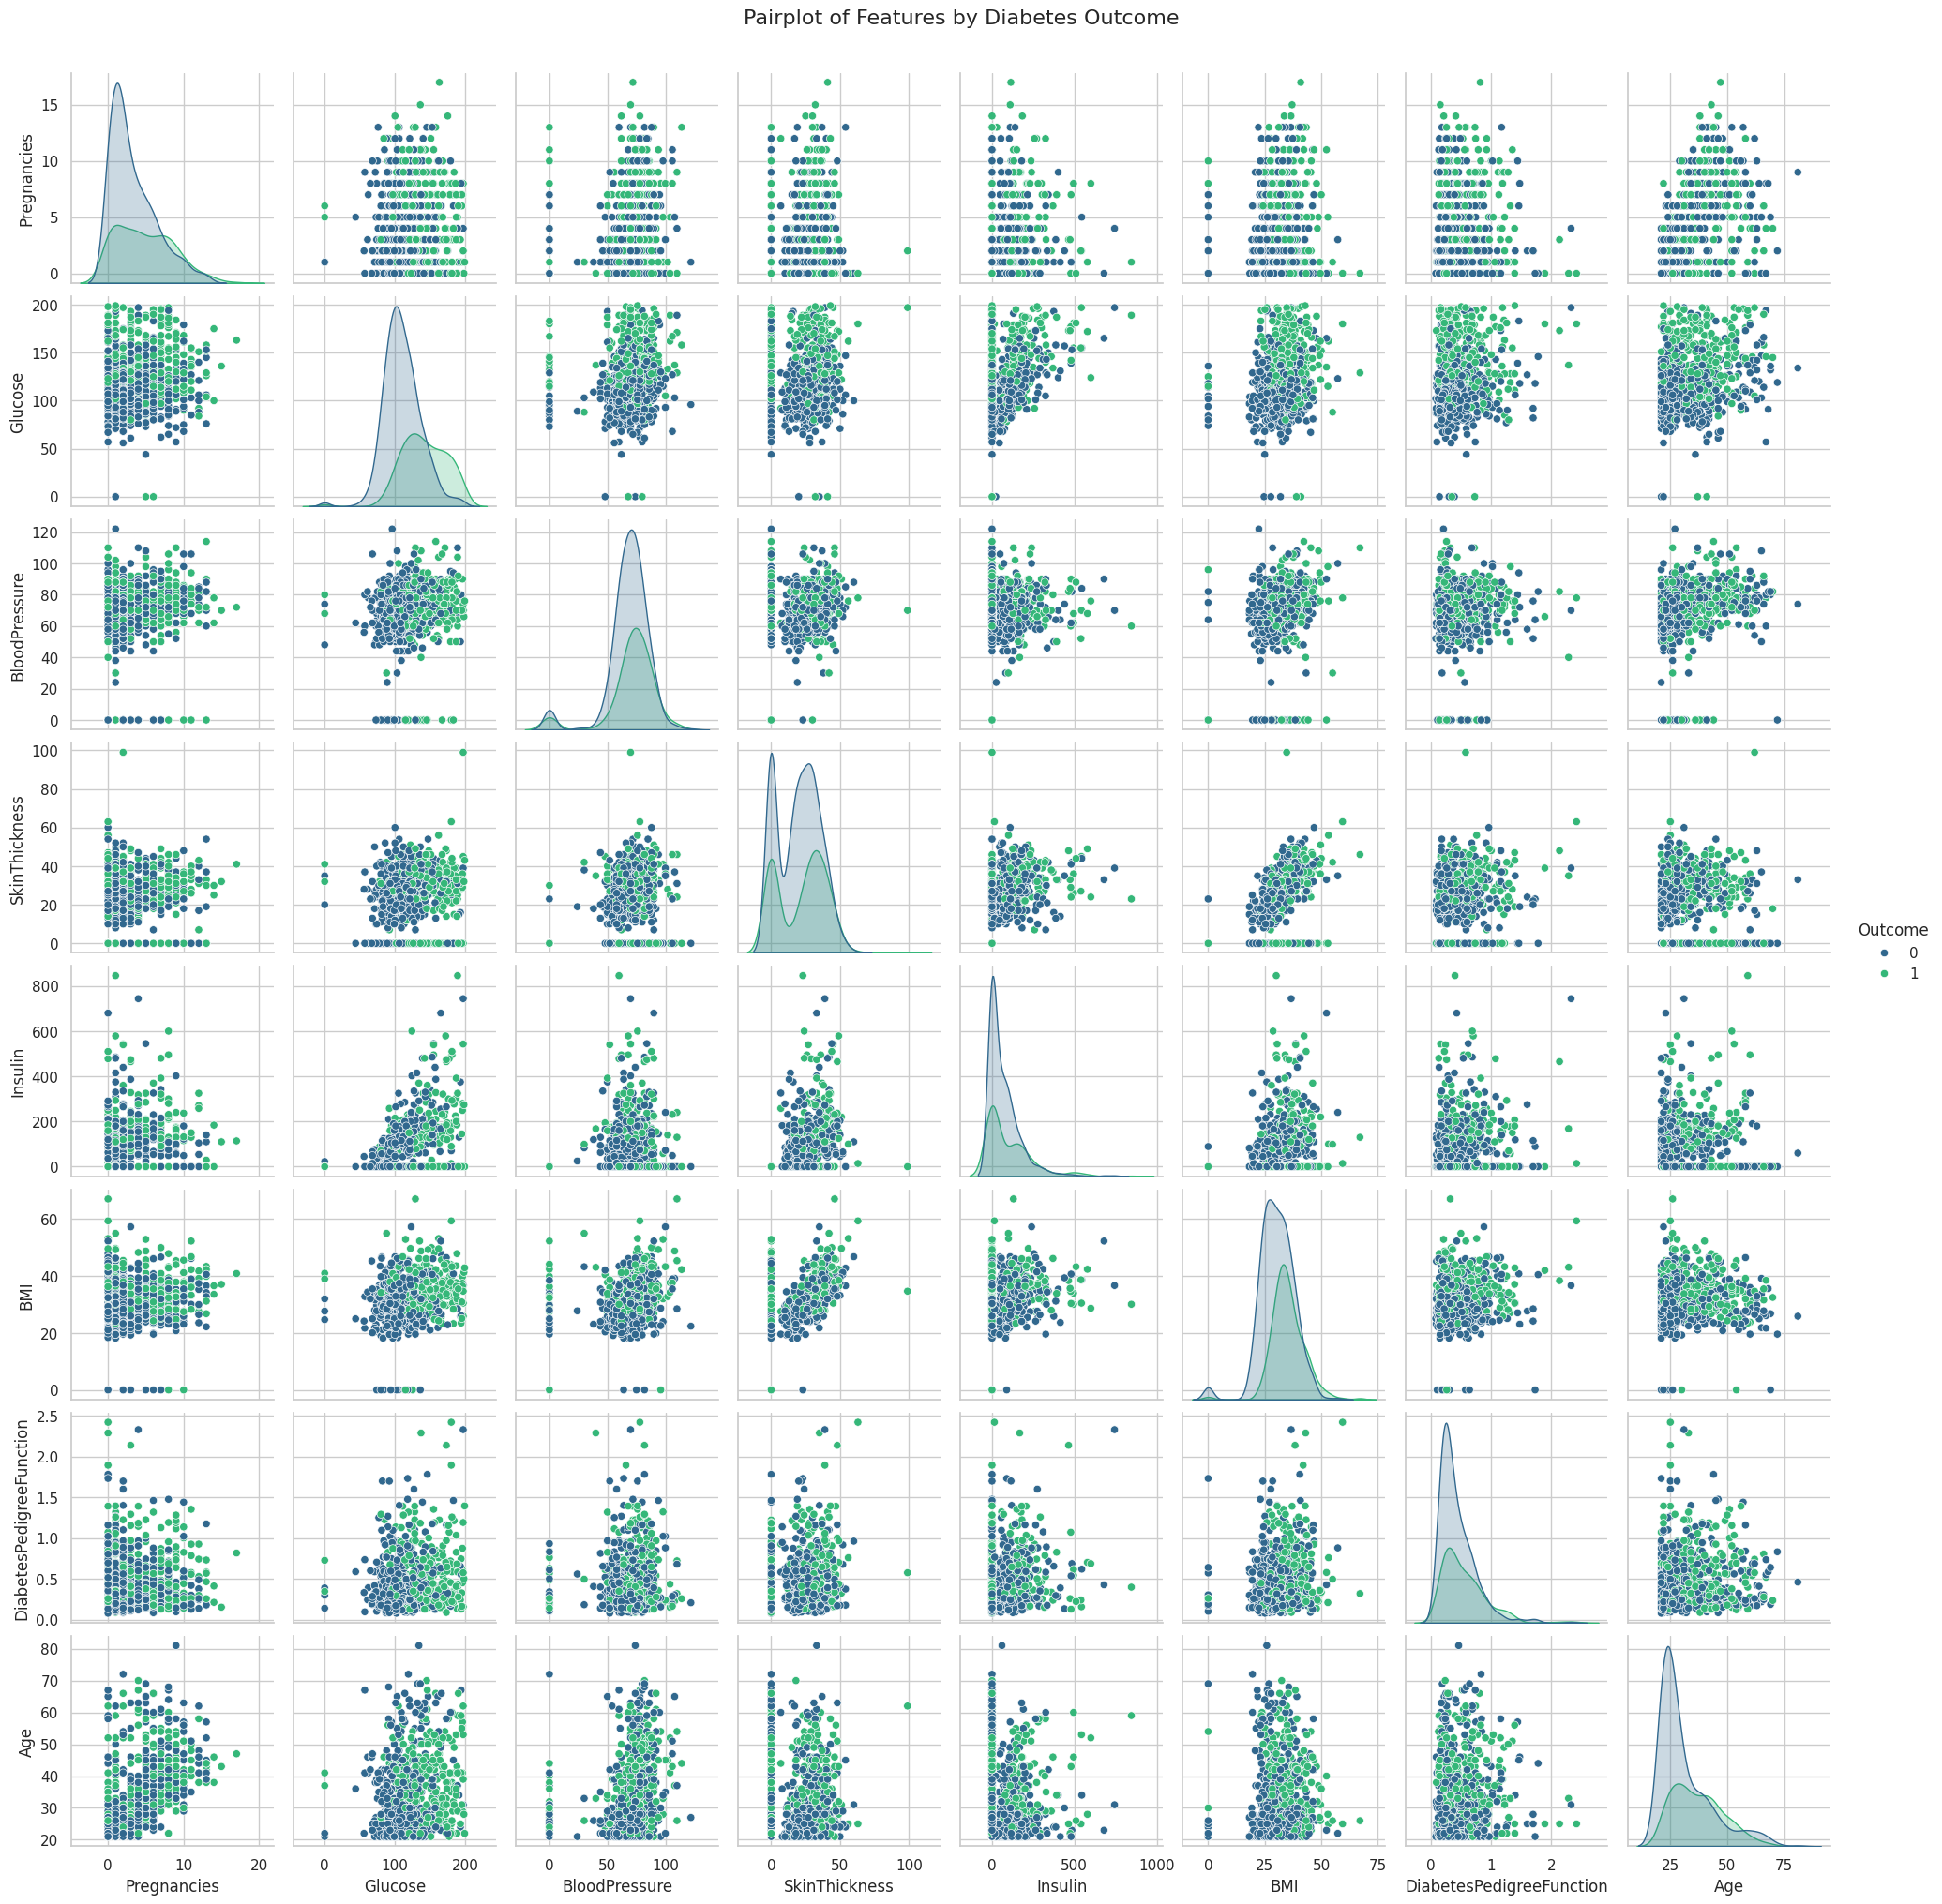

In [ ]:
# Pairplot to visualize relationships between features
plt.figure(figsize=(12, 10))
sns.pairplot(df, hue='Outcome', diag_kind='kde', palette='viridis')
plt.suptitle('Pairplot of Features by Diabetes Outcome', y=1.02, fontsize=16)
plt.show()
plt.close()

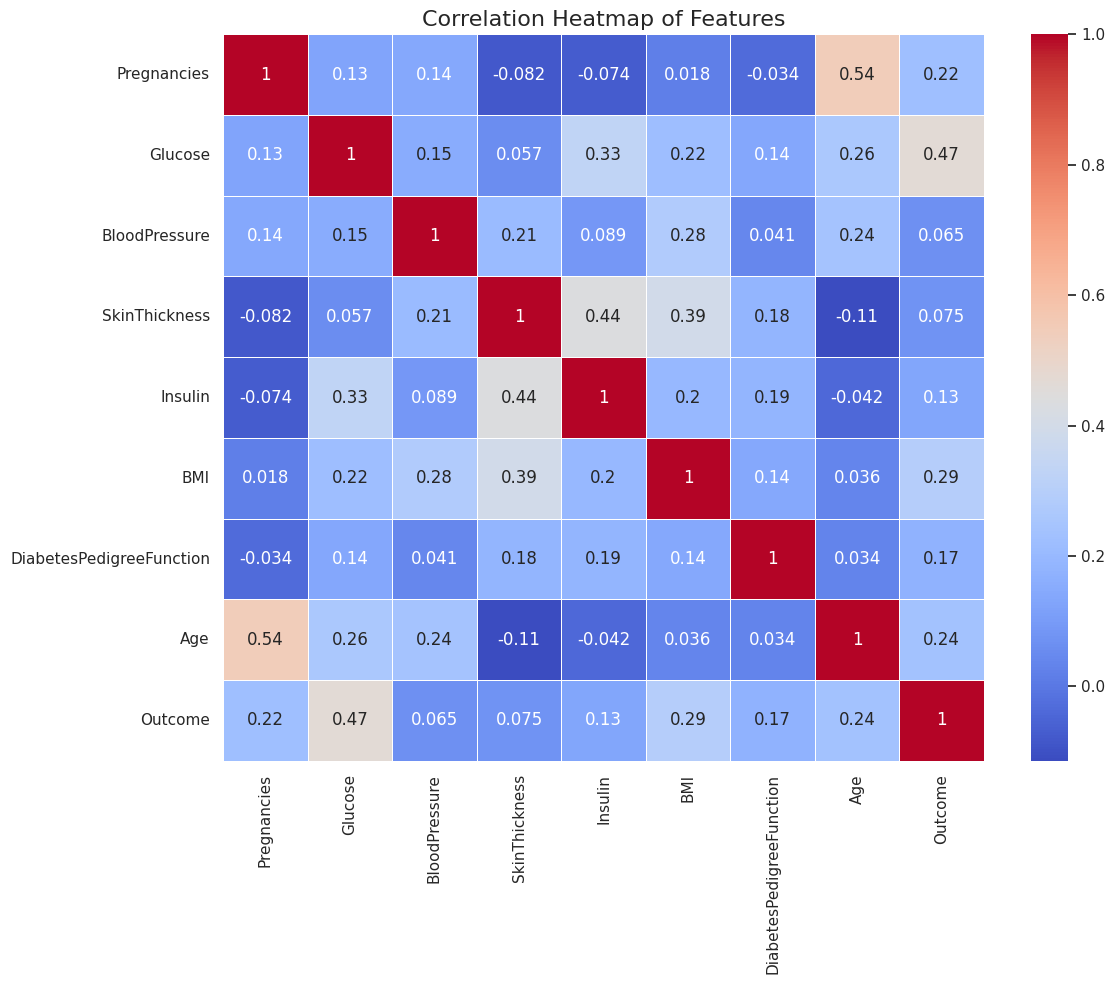

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features', fontsize=16)
plt.tight_layout()
plt.show()
plt.close()

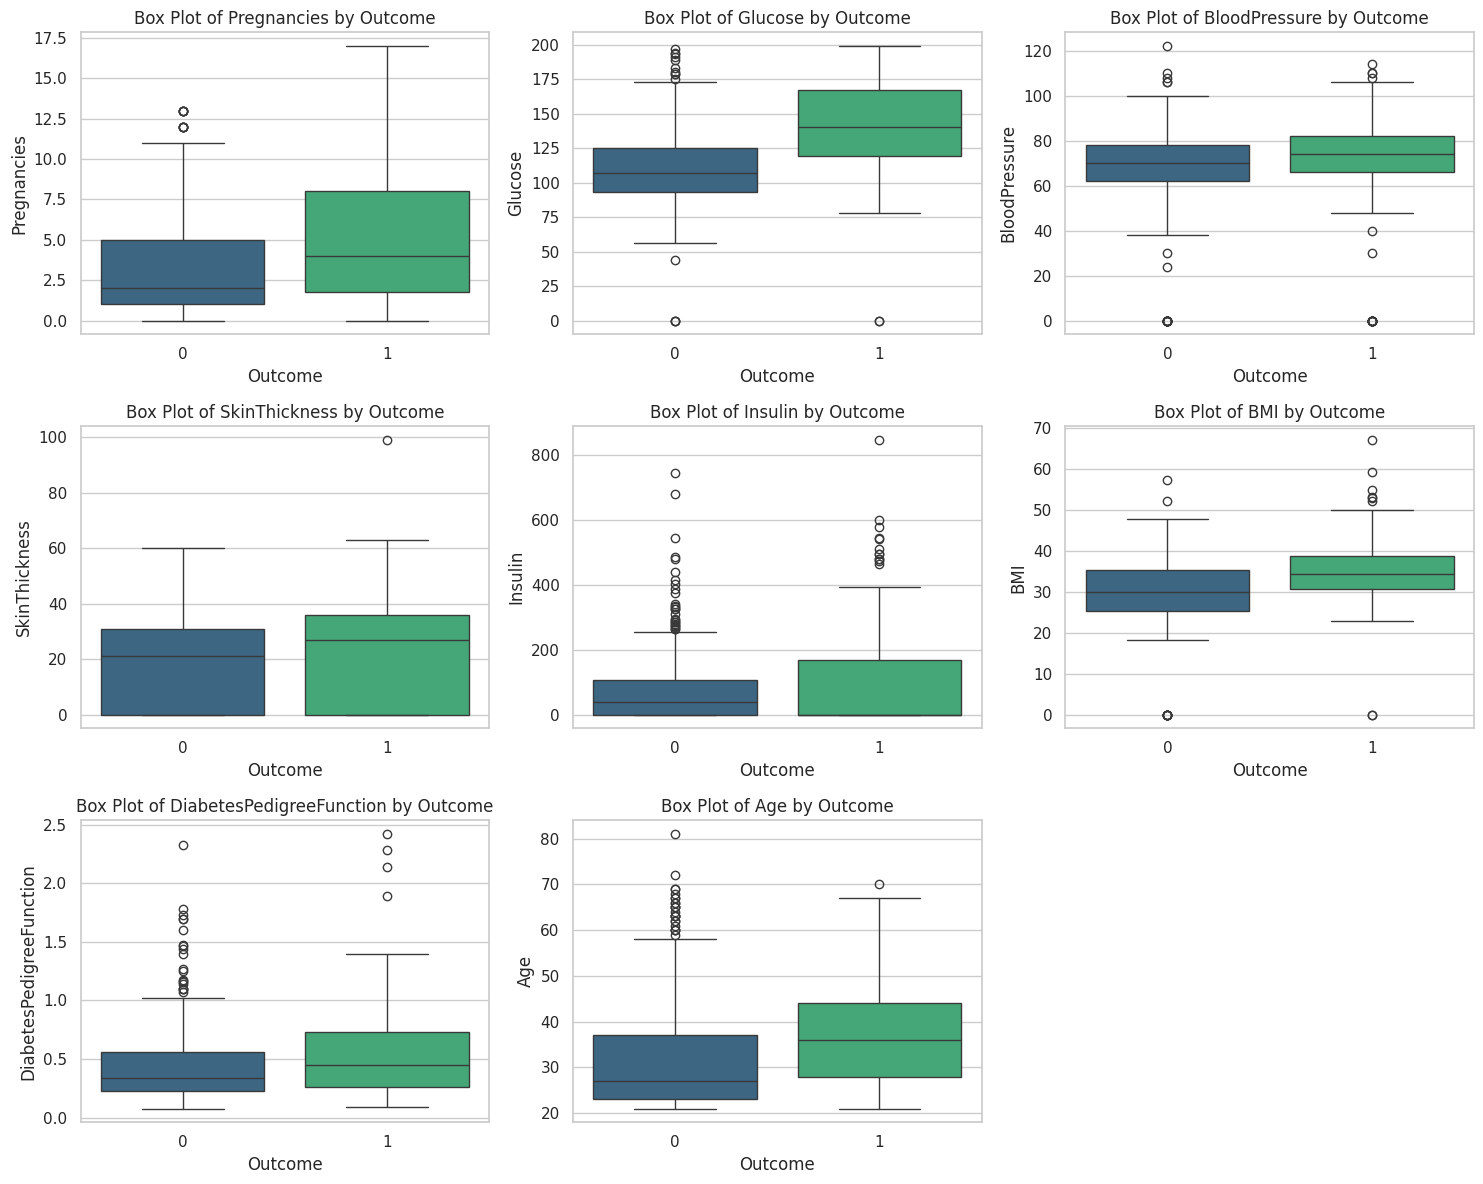

In [ ]:
# Box plots to identify outliers
plt.figure(figsize=(15, 12))
for i, column in enumerate(df.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='Outcome', y=column, data=df, palette='viridis')
    plt.title(f'Box Plot of {column} by Outcome')
plt.tight_layout()
plt.show()
plt.close()

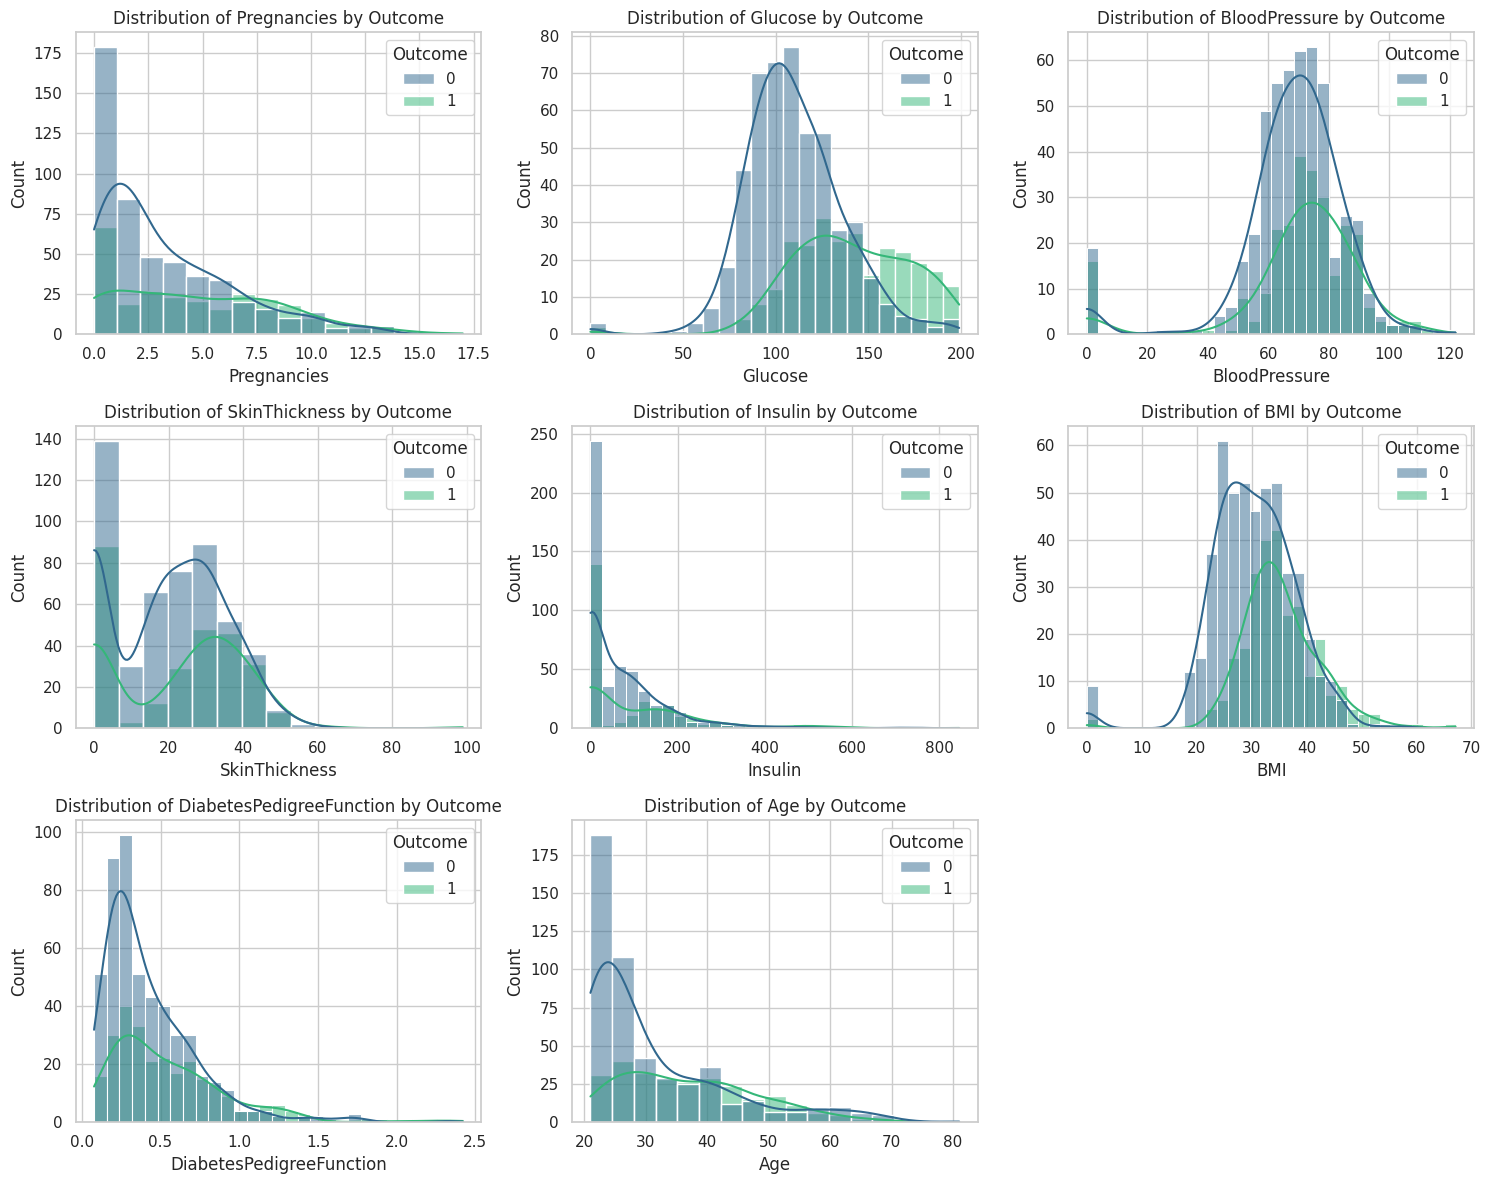

In [ ]:
# Distribution of features by outcome
plt.figure(figsize=(15, 12))
for i, column in enumerate(df.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=column, hue='Outcome', kde=True, palette='viridis')
    plt.title(f'Distribution of {column} by Outcome')
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
# Data PreProcessing
df_processed = df.copy()

In [ ]:
for column in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    df_processed[column] = df_processed[column].replace(0, np.nan)
    median_value = df_processed[column].median(skipna=True)
    df_processed[column].fillna(median_value, inplace=True)

print("\nAfter handling zero values:")
print(df_processed.describe())

# Create new features
# BMI Categories
df_processed['BMI_Category'] = pd.cut(
    df_processed['BMI'],
    bins=[0, 18.5, 25, 30, 100],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese']
)

# Age Groups
df_processed['Age_Group'] = pd.cut(
    df_processed['Age'],
    bins=[20, 30, 40, 50, 100],
    labels=['20-30', '30-40', '40-50', '50+']
)

# Glucose Level Categories
df_processed['Glucose_Category'] = pd.cut(
    df_processed['Glucose'],
    bins=[0, 70, 100, 126, 200],
    labels=['Low', 'Normal', 'Pre-diabetic', 'Diabetic']
)

# Convert categorical features to dummy variables
df_processed = pd.get_dummies(
    df_processed,
    columns=['BMI_Category', 'Age_Group', 'Glucose_Category'],
    drop_first=True
)

print("\nAfter feature engineering:")
print(df_processed.head())
print(f"Number of features: {df_processed.shape[1]}")


After handling zero values:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      29.108073  140.671875   
std       3.369578   30.438286      12.096642       8.791221   86.383060   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  121.500000   
50%       3.000000  117.000000      72.000000      29.000000  125.000000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.455208                  0.471876   33.240885    0.348958  
std      6.875177                  0.331329   11.760232    0.476951  
min   

In [ ]:
# Check for outliers using IQR method
def detect_outliers(df, features):
    outlier_indices = []

    for feature in features:
        # Calculate Q1, Q3, and IQR
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier bounds
        outlier_step = IQR * 1.5

        # Find outlier indices
        feature_outliers = df[(df[feature] < Q1 - outlier_step) | (df[feature] > Q3 + outlier_step)].index
        outlier_indices.extend(feature_outliers)

    return outlier_indices


In [ ]:
# Detect outliers in numerical features
numerical_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                      'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
outlier_indices = detect_outliers(df_processed, numerical_features)

print(f"\nNumber of outliers detected: {len(set(outlier_indices))}")
print(f"Percentage of data that are outliers: {len(set(outlier_indices))/len(df_processed)*100:.2f}%")

# Instead of removing outliers, let's use robust models that can handle outliers well
# Split data into features and target
X = df_processed.drop(['Outcome'], axis=1)
y = df_processed['Outcome']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Number of outliers detected: 393
Percentage of data that are outliers: 51.17%

Training set shape: (614, 17)
Testing set shape: (154, 17)


In [ ]:
# Model Training
models = {
    'Logistic Regression': LogisticRegression(class_weight={0:1, 1:2}, max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight={0:1, 1:2}, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),  # Handles imbalance differently
    'SVM': SVC(class_weight={0:1, 1:2}, probability=True, random_state=42),
    'KNN': KNeighborsClassifier()  # KNN doesn't support class weights directly
}

# Function to evaluate model performance with focus on false positive/negative balance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Create a pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)

    # Extract confusion matrix metrics
    tn, fp, fn, tp = cm.ravel()

    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"True Negatives: {tn}, False Positives: {fp}")
    print(f"False Negatives: {fn}, True Positives: {tp}")
    print(f"FP/FN Ratio: {fp/max(1, fn):.2f}")
    print(f"Classification Report:\n{report}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    plt.close()

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    plt.close()

    return {
        'model': pipeline,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'roc_auc': roc_auc,
        'fp_fn_ratio': fp/max(1, fn)
    }



Logistic Regression Evaluation:
Accuracy: 0.7662
Precision: 0.6364
Recall: 0.7778
F1 Score: 0.7000
Confusion Matrix:
[[76 24]
 [12 42]]
True Negatives: 76, False Positives: 24
False Negatives: 12, True Positives: 42
FP/FN Ratio: 2.00
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.76      0.81       100
           1       0.64      0.78      0.70        54

    accuracy                           0.77       154
   macro avg       0.75      0.77      0.75       154
weighted avg       0.78      0.77      0.77       154



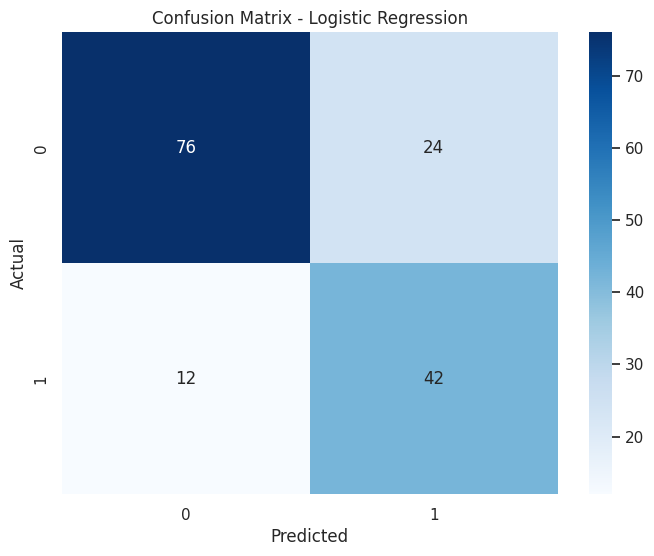

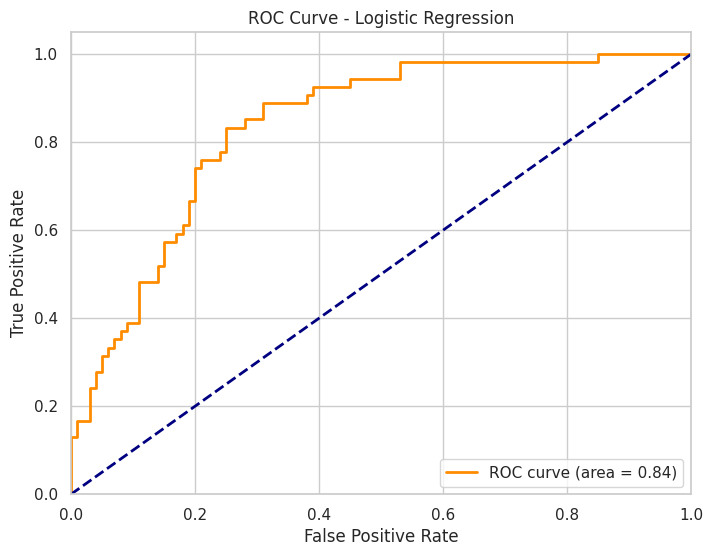


Random Forest Evaluation:
Accuracy: 0.7403
Precision: 0.6522
Recall: 0.5556
F1 Score: 0.6000
Confusion Matrix:
[[84 16]
 [24 30]]
True Negatives: 84, False Positives: 16
False Negatives: 24, True Positives: 30
FP/FN Ratio: 0.67
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       100
           1       0.65      0.56      0.60        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.74      0.73       154



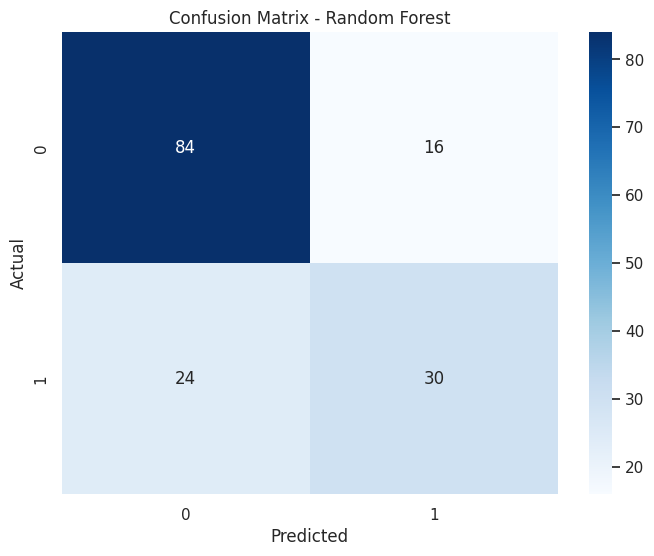

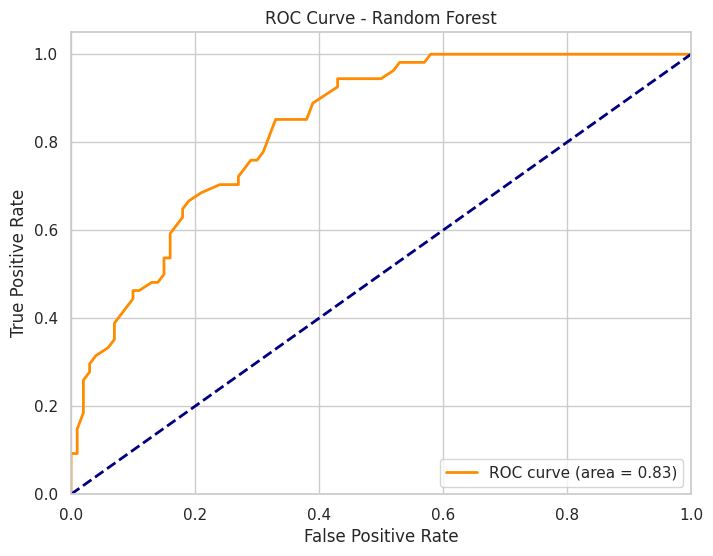


Gradient Boosting Evaluation:
Accuracy: 0.7403
Precision: 0.6458
Recall: 0.5741
F1 Score: 0.6078
Confusion Matrix:
[[83 17]
 [23 31]]
True Negatives: 83, False Positives: 17
False Negatives: 23, True Positives: 31
FP/FN Ratio: 0.74
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.81       100
           1       0.65      0.57      0.61        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.71       154
weighted avg       0.73      0.74      0.74       154



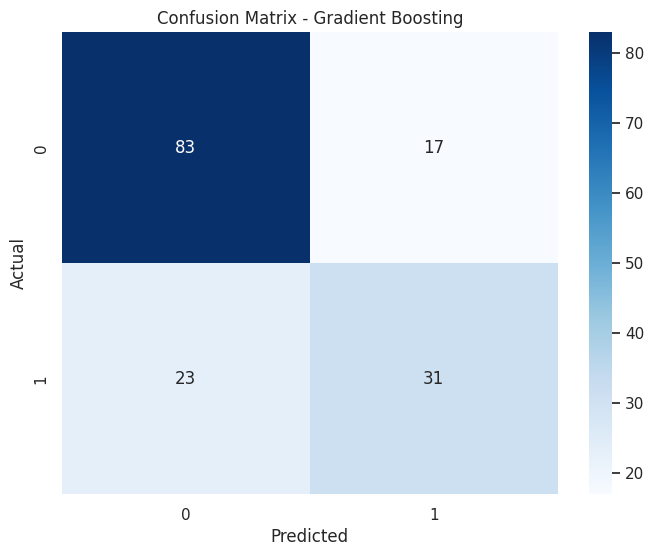

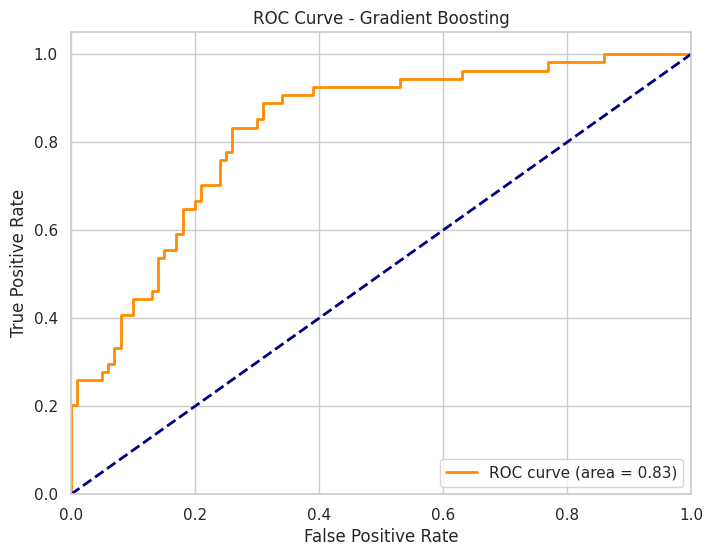


SVM Evaluation:
Accuracy: 0.7662
Precision: 0.6324
Recall: 0.7963
F1 Score: 0.7049
Confusion Matrix:
[[75 25]
 [11 43]]
True Negatives: 75, False Positives: 25
False Negatives: 11, True Positives: 43
FP/FN Ratio: 2.27
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.75      0.81       100
           1       0.63      0.80      0.70        54

    accuracy                           0.77       154
   macro avg       0.75      0.77      0.76       154
weighted avg       0.79      0.77      0.77       154



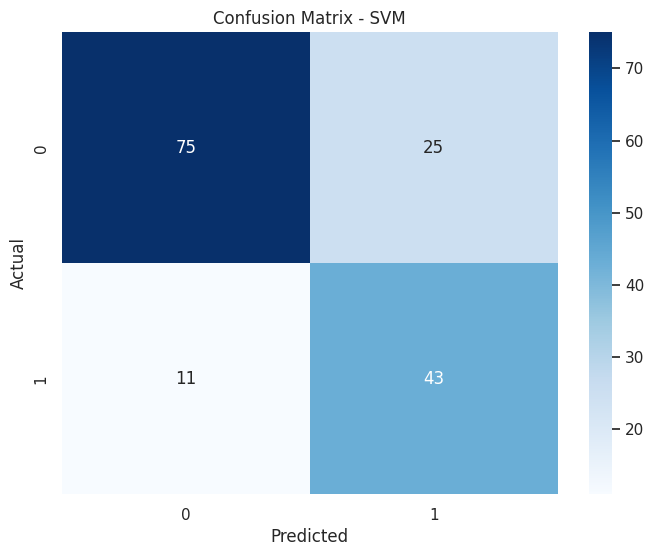

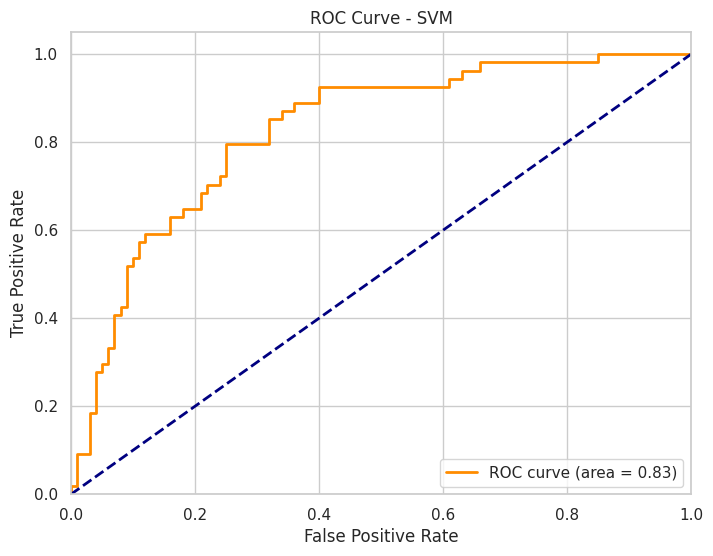


KNN Evaluation:
Accuracy: 0.7597
Precision: 0.6604
Recall: 0.6481
F1 Score: 0.6542
Confusion Matrix:
[[82 18]
 [19 35]]
True Negatives: 82, False Positives: 18
False Negatives: 19, True Positives: 35
FP/FN Ratio: 0.95
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       100
           1       0.66      0.65      0.65        54

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.74       154
weighted avg       0.76      0.76      0.76       154



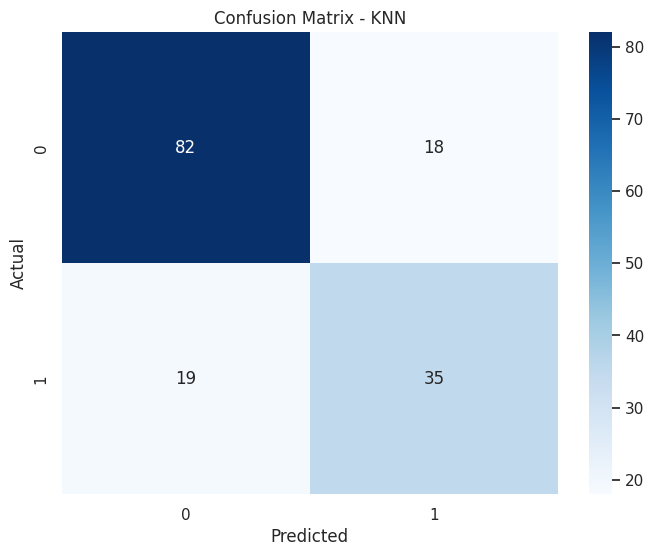

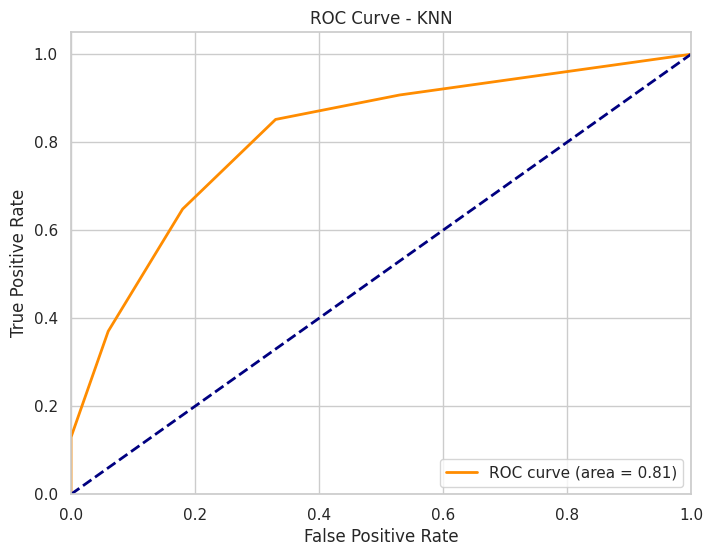

In [ ]:
# Evaluate each model
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train, X_test, y_train, y_test, name)


Model Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score  \
3                  SVM  0.766234   0.632353  0.796296  0.704918   
0  Logistic Regression  0.766234   0.636364  0.777778  0.700000   
4                  KNN  0.759740   0.660377  0.648148  0.654206   
2    Gradient Boosting  0.740260   0.645833  0.574074  0.607843   
1        Random Forest  0.740260   0.652174  0.555556  0.600000   

   False Positives  False Negatives  FP to FN Ratio   ROC AUC  
3               25               11        2.272727  0.825926  
0               24               12        2.000000  0.836111  
4               18               19        0.947368  0.812778  
2               17               23        0.739130  0.827222  
1               16               24        0.666667  0.832222  

Best Model based on FP > FN requirement: SVM

Fine-tuning SVM with focus on FP > FN...

Best parameters: {'model__C': 10, 'model__class_weight': {0: 1, 1: 3}, 'model__gamma': 'scale', 'model__k

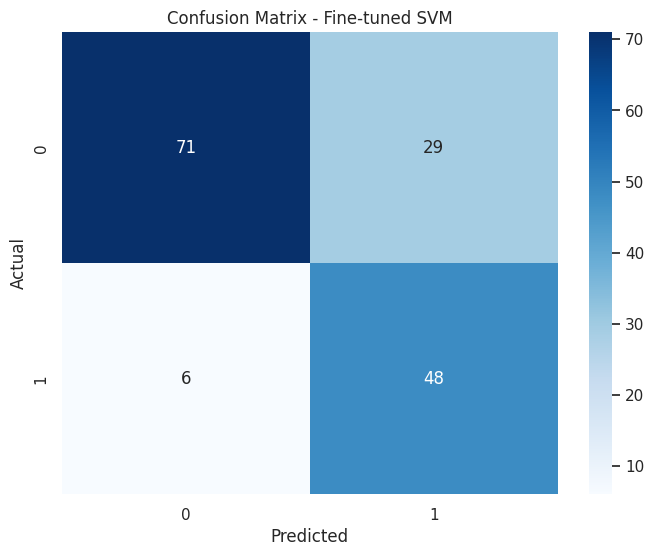

In [ ]:
# Model comparison
# Compare models based on accuracy and false negative rate
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results],
    'Precision': [results[model]['precision'] for model in results],
    'Recall': [results[model]['recall'] for model in results],
    'F1 Score': [results[model]['f1'] for model in results],
    'False Positives': [results[model]['fp'] for model in results],
    'False Negatives': [results[model]['fn'] for model in results],
    'FP to FN Ratio': [results[model]['fp_fn_ratio'] for model in results],
    'ROC AUC': [results[model]['roc_auc'] for model in results]
})

print("\nModel Comparison:")
print(model_comparison.sort_values('FP to FN Ratio', ascending=False))

# Select best model based on FP > FN requirement
best_model_name = model_comparison.sort_values('FP to FN Ratio', ascending=False).iloc[0]['Model']
print(f"\nBest Model based on FP > FN requirement: {best_model_name}")

# If none of the models have FP > FN, we can try adjusting the prediction threshold
if model_comparison['FP to FN Ratio'].max() < 1.0:
    print("\nNone of the models naturally produce FP > FN. Adjusting prediction thresholds...")

    for name, model_result in results.items():
        pipeline = model_result['model']
        y_prob = pipeline.predict_proba(X_test)[:, 1]

        # Try different thresholds to find one that gives us more FP than FN
        thresholds = np.arange(0.3, 0.6, 0.05)
        best_threshold = 0.5  # Default
        best_ratio = 0

        for threshold in thresholds:
            y_pred_adjusted = (y_prob >= threshold).astype(int)
            cm = confusion_matrix(y_test, y_pred_adjusted)
            tn, fp, fn, tp = cm.ravel()
            ratio = fp / max(1, fn)

            # We want the highest ratio that's greater than 1
            if ratio > best_ratio and ratio >= 1:
                best_ratio = ratio
                best_threshold = threshold
                best_cm = cm

        print(f"\n{name} with threshold {best_threshold:.2f}:")
        tn, fp, fn, tp = best_cm.ravel()
        print(f"Confusion Matrix:\n{best_cm}")
        print(f"FP/FN Ratio: {fp/max(1, fn):.2f}")

        # Update the results with the adjusted predictions
        results[name]['threshold_adjusted'] = best_threshold
        results[name]['fp_fn_ratio_adjusted'] = fp/max(1, fn)

    # Update model comparison with threshold-adjusted metrics
    model_comparison['Adjusted Threshold'] = [
        results[model].get('threshold_adjusted', 0.5) for model in results
    ]
    model_comparison['FP to FN Ratio (Adjusted)'] = [
        results[model].get('fp_fn_ratio_adjusted', results[model]['fp_fn_ratio']) for model in results
    ]

    print("\nModel Comparison after Threshold Adjustment:")
    print(model_comparison.sort_values('FP to FN Ratio (Adjusted)', ascending=False))

    # Select the best model after adjustment
    best_model_name = model_comparison.sort_values('FP to FN Ratio (Adjusted)', ascending=False).iloc[0]['Model']
    print(f"\nBest Model after threshold adjustment: {best_model_name}")

# 6. Fine-tune the best model
print(f"\nFine-tuning {best_model_name} with focus on FP > FN...")

# Set up parameter grids for fine-tuning with focus on class weights
if best_model_name == 'Logistic Regression':
    param_grid = {
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'lbfgs'],
        'model__class_weight': [{0:1, 1:1.5}, {0:1, 1:2}, {0:1, 1:3}, 'balanced']
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__class_weight': [{0:1, 1:1.5}, {0:1, 1:2}, {0:1, 1:3}, 'balanced']
    }
elif best_model_name == 'Gradient Boosting':
    # Gradient Boosting doesn't have a class_weight parameter, but we can adjust scale_pos_weight
    # This parameter gives more weight to positive examples
    param_grid = {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.8, 1.0]
    }
elif best_model_name == 'SVM':
    param_grid = {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto', 0.1],
        'model__class_weight': [{0:1, 1:1.5}, {0:1, 1:2}, {0:1, 1:3}, 'balanced']
    }
else:  # KNN
    # KNN doesn't support class weights directly, so we'll use other parameters
    param_grid = {
        'model__n_neighbors': [3, 5, 7, 9, 11],
        'model__weights': ['uniform', 'distance'],
        'model__metric': ['euclidean', 'manhattan']
    }

# Create pipeline for grid search
best_model = results[best_model_name]['model']

# Define a custom scoring function that prioritizes FP > FN
def custom_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    # We want to maximize the FP/FN ratio while keeping accuracy reasonable
    fp_fn_ratio = fp / max(1, fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    # Penalize if fp_fn_ratio < 1 (we want more FP than FN)
    if fp_fn_ratio < 1:
        return 0
    # Otherwise, balance between accuracy and having a reasonable FP to FN ratio
    return accuracy * min(fp_fn_ratio, 3)  # Cap the ratio impact to avoid extreme cases

# Perform grid search with our custom scorer
grid_search = GridSearchCV(
    best_model,
    param_grid,
    cv=5,
    scoring=custom_scorer if best_model_name != 'KNN' else 'accuracy',  # Use normal accuracy for KNN
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate the fine-tuned model
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)
y_prob = best_pipeline.predict_proba(X_test)[:, 1]

# If the model is KNN (which doesn't directly support class weights),
# we may need to adjust the threshold to achieve FP > FN
if best_model_name == 'KNN':
    # Try different thresholds
    best_threshold = 0.5
    best_fp_fn_ratio = 0

    for threshold in np.arange(0.3, 0.7, 0.05):
        y_pred_threshold = (y_prob >= threshold).astype(int)
        cm = confusion_matrix(y_test, y_pred_threshold)
        tn, fp, fn, tp = cm.ravel()
        fp_fn_ratio = fp / max(1, fn)

        if fp_fn_ratio > 1 and fp_fn_ratio > best_fp_fn_ratio:
            best_threshold = threshold
            best_fp_fn_ratio = fp_fn_ratio
            y_pred = y_pred_threshold

    print(f"For KNN, using a threshold of {best_threshold} to achieve FP > FN")

# Calculate final metrics
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nFine-tuned {best_model_name} Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{cm}")
print(f"True Negatives: {tn}, False Positives: {fp}")
print(f"False Negatives: {fn}, True Positives: {tp}")
print(f"FP to FN Ratio: {fp/max(1, fn):.2f}")
print(f"Classification Report:\n{report}")

# Plot final confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - Fine-tuned {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
plt.close()


In [ ]:
#feature Important analysis
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    # For tree-based models, we can get feature importance directly
    importances = best_pipeline.named_steps['model'].feature_importances_
    feature_names = X.columns

    # Create DataFrame for better visualization
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print("\nFeature Importance:")
    print(feature_importance.head(10))

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()
elif best_model_name == 'Logistic Regression':
    # For logistic regression, we can get coefficients
    coefficients = best_pipeline.named_steps['model'].coef_[0]
    feature_names = X.columns

    # Create DataFrame for better visualization
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    print("\nLogistic Regression Coefficients:")
    print(feature_importance.head(10))

    # Plot coefficients
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(15))
    plt.title('Feature Coefficients - Logistic Regression')
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
# Save the Best model
model_info = {
    'model': best_pipeline,
    'feature_names': list(X.columns),
    'model_name': best_model_name,
    'metrics': {
        'accuracy': accuracy,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'tn': tn,
        'fp_fn_ratio': fp/max(1, fn),
    }
}

joblib.dump(model_info, 'diabetes_prediction_model.pkl')
print(f"Best model ({best_model_name}) saved as 'diabetes_prediction_model.pkl'")

print("\nComplete Machine Learning Pipeline with FP > FN Optimization Executed Successfully!")

# For deployment, we would use the saved model in a web application or API
print("\nThe model is now ready for deployment in a web application.")

Best model (SVM) saved as 'diabetes_prediction_model.pkl'

Complete Machine Learning Pipeline with FP > FN Optimization Executed Successfully!

The model is now ready for deployment in a web application.
